# Volts Volatility-Based Predictive Trading Strategy

This notebook implements the complete Volts strategy pipeline:

1. **Data Acquisition** - Download historical price data
2. **Volatility Estimation** - Calculate historical volatility using multiple estimators
3. **Volatility Clustering** - Group assets by volatility characteristics
4. **Granger Causality Testing** - Identify predictive relationships
5. **Signal Generation** - Generate trading signals based on trends
6. **Backtesting** - Evaluate strategy performance

Run each cell sequentially to execute the complete strategy.

## Setup and Configuration

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import yaml
import warnings
from pathlib import Path
from datetime import datetime

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Execution started at: 2026-01-24 18:06:03


In [2]:
# Import strategy modules
from volatility_estimators import VolatilityEstimator, calculate_volatility_for_assets
from volatility_clustering import VolatilityClustering, cluster_assets_by_volatility
from granger_causality import GrangerCausalityAnalyzer, identify_trading_pairs
from signal_generator import SignalGenerator, SignalAnalyzer
from backtester import VoltBacktester

print("Strategy modules imported successfully!")

Strategy modules imported successfully!


In [3]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Assets: {config['data']['assets']}")
print(f"Data period: {config['data']['start_date']} to {config['data']['end_date']}")
print(f"Volatility estimator: {config['volatility']['primary_estimator']}")
print(f"Rolling window: {config['volatility']['rolling_window']} days")
print(f"Target cluster: Mid-volatility")
print(f"Optimal lag: {config['granger']['optimal_lag']} days")

Configuration loaded:
Assets: ['MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'QCOM', 'IBM', 'INTC', 'MU']
Data period: 2020-01-01 to 2025-12-31
Volatility estimator: yang_zhang
Rolling window: 20 days
Target cluster: Mid-volatility
Optimal lag: 5 days


## Step 1: Data Acquisition

Download historical OHLC price data for all assets in our universe.

**Data Sources:**
- **Primary:** Alpaca API (faster, more reliable, no timeouts)
- **Fallback:** yfinance with retry logic


In [7]:
print("="*80)
print("STEP 1: DATA ACQUISITION")
print("="*80)

tickers = config['data']['assets']
start_date = config['data']['start_date']
end_date = config['data']['end_date']

from data_fetcher import download_data
data_dict = download_data(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    source='auto',  # Try Alpaca first, fallback to yfinance
    max_retries=3   # For yfinance fallback
)

print(f"\nSuccessfully downloaded data for {len(data_dict)}/{len(tickers)} assets")

if len(data_dict) < len(tickers):
    missing = set(tickers) - set(data_dict.keys())
    print(f"\n Missing data for: {missing}")
    print("These tickers will be excluded from the analysis.")

STEP 1: DATA ACQUISITION
Period: 2020-01-01 to 2025-12-31

Using yfinance

  Fetching MSFT from yfinance (attempt 1/3)...
    MSFT: 1507 days ✓
  Fetching GOOGL from yfinance (attempt 1/3)...
    GOOGL: 1507 days ✓
  Fetching NVDA from yfinance (attempt 1/3)...
    NVDA: 1507 days ✓
  Fetching AMZN from yfinance (attempt 1/3)...
    AMZN: 1507 days ✓
  Fetching META from yfinance (attempt 1/3)...
    META: 1507 days ✓
  Fetching QCOM from yfinance (attempt 1/3)...
    QCOM: 1507 days ✓
  Fetching IBM from yfinance (attempt 1/3)...
    IBM: 1507 days ✓
  Fetching INTC from yfinance (attempt 1/3)...
    INTC: 1507 days ✓
  Fetching MU from yfinance (attempt 1/3)...
    MU: 1507 days ✓

Successfully downloaded data for 9/9 assets


In [8]:
# Retry failed tickers
missing_tickers = list(set(config['data']['assets']) - set(data_dict.keys()))

if len(missing_tickers) > 0:
    print(f"Retrying {len(missing_tickers)} failed tickers: {missing_tickers}\n")
    
    retry_data = download_data(
        tickers=missing_tickers,
        start_date=start_date,
        end_date=end_date,
        source='yfinance',  # Force yfinance with more retries
        max_retries=5       # More attempts
    )
    
    # Add successfully retrieved data
    for ticker, df in retry_data.items():
        data_dict[ticker] = df
        print(f"✓ Successfully added {ticker}")
    
    print(f"\nTotal assets now: {len(data_dict)}/{len(config['data']['assets'])}")
else:
    print("No failed tickers to retry!")

No failed tickers to retry!


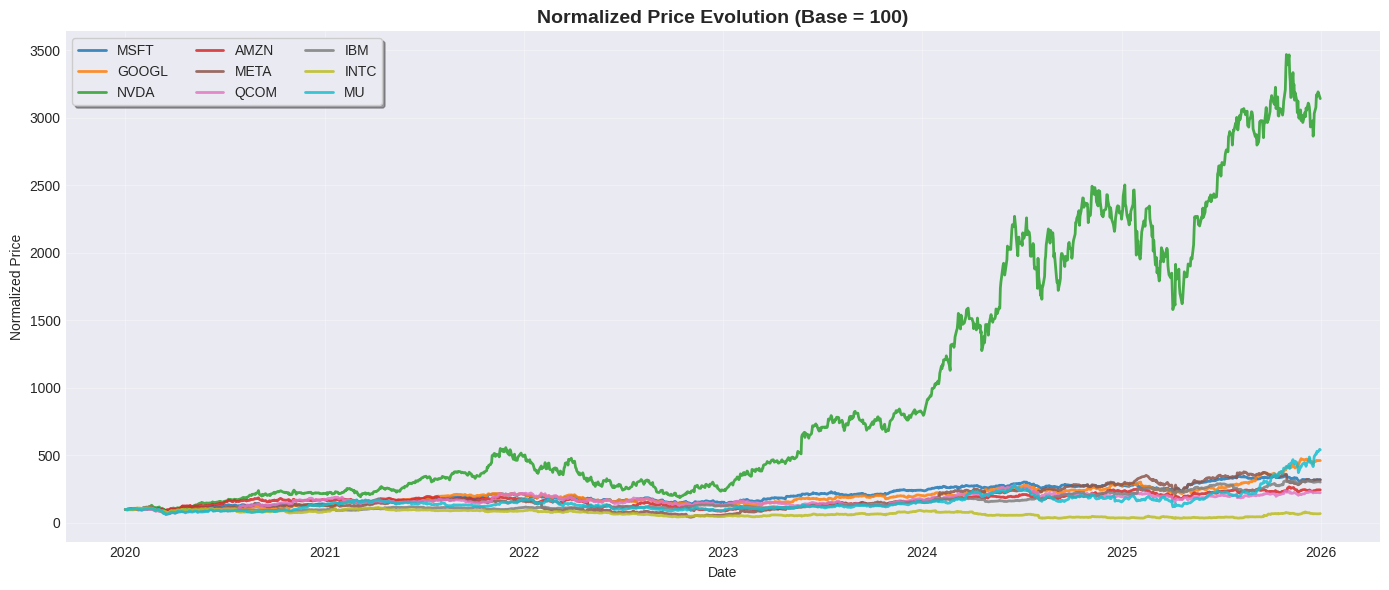


Data date range: 2020-01-02 00:00:00 to 2025-12-30 00:00:00


In [9]:
# Quick visualization of price data
fig, ax = plt.subplots(figsize=(14, 6))

# Use a distinct color palette with enough colors
colors = plt.cm.tab10(np.linspace(0, 1, len(data_dict)))

for idx, (ticker, df) in enumerate(data_dict.items()):
    # Normalize to 100 for comparison
    normalized = (df['Close'] / df['Close'].iloc[0]) * 100
    ax.plot(normalized.index, normalized.values, label=ticker, 
            color=colors[idx], alpha=0.85, linewidth=2)

ax.set_title('Normalized Price Evolution (Base = 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.legend(loc='best', ncol=3, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nData date range: {list(data_dict.values())[0].index[0]} to {list(data_dict.values())[0].index[-1]}")

## Step 2: Historical Volatility Estimation

Calculate historical volatility using the Yang-Zhang estimator (robust to opening jumps and drift).

In [10]:
print("="*80)
print("STEP 2: VOLATILITY ESTIMATION")
print("="*80)

vol_config = config['volatility']
print(f"\nUsing {vol_config['primary_estimator']} estimator")
print(f"Rolling window: {vol_config['rolling_window']} days")
print(f"Annualization factor: {vol_config['annualization_factor']}\n")

# Calculate volatility for all assets
volatility_df = calculate_volatility_for_assets(
    data_dict,
    estimator=vol_config['primary_estimator'],
    rolling_window=vol_config['rolling_window'],
    annualization_factor=vol_config['annualization_factor']
)

# Remove NaN values
volatility_df = volatility_df.dropna()

print(f"Volatility calculated for period: {volatility_df.index[0]} to {volatility_df.index[-1]}")
print(f"Data points: {len(volatility_df)}")
print("\nMean volatility by asset:")
mean_vols = volatility_df.mean().sort_values(ascending=False)
for ticker, vol in mean_vols.items():
    print(f"  {ticker}: {vol:.2%}")

STEP 2: VOLATILITY ESTIMATION

Using yang_zhang estimator
Rolling window: 20 days
Annualization factor: 252

Volatility calculated for period: 2020-01-31 00:00:00 to 2025-12-30 00:00:00
Data points: 1487

Mean volatility by asset:
  NVDA: 50.78%
  MU: 48.71%
  INTC: 43.84%
  META: 42.20%
  QCOM: 38.92%
  AMZN: 35.63%
  GOOGL: 32.49%
  MSFT: 27.82%
  IBM: 25.71%


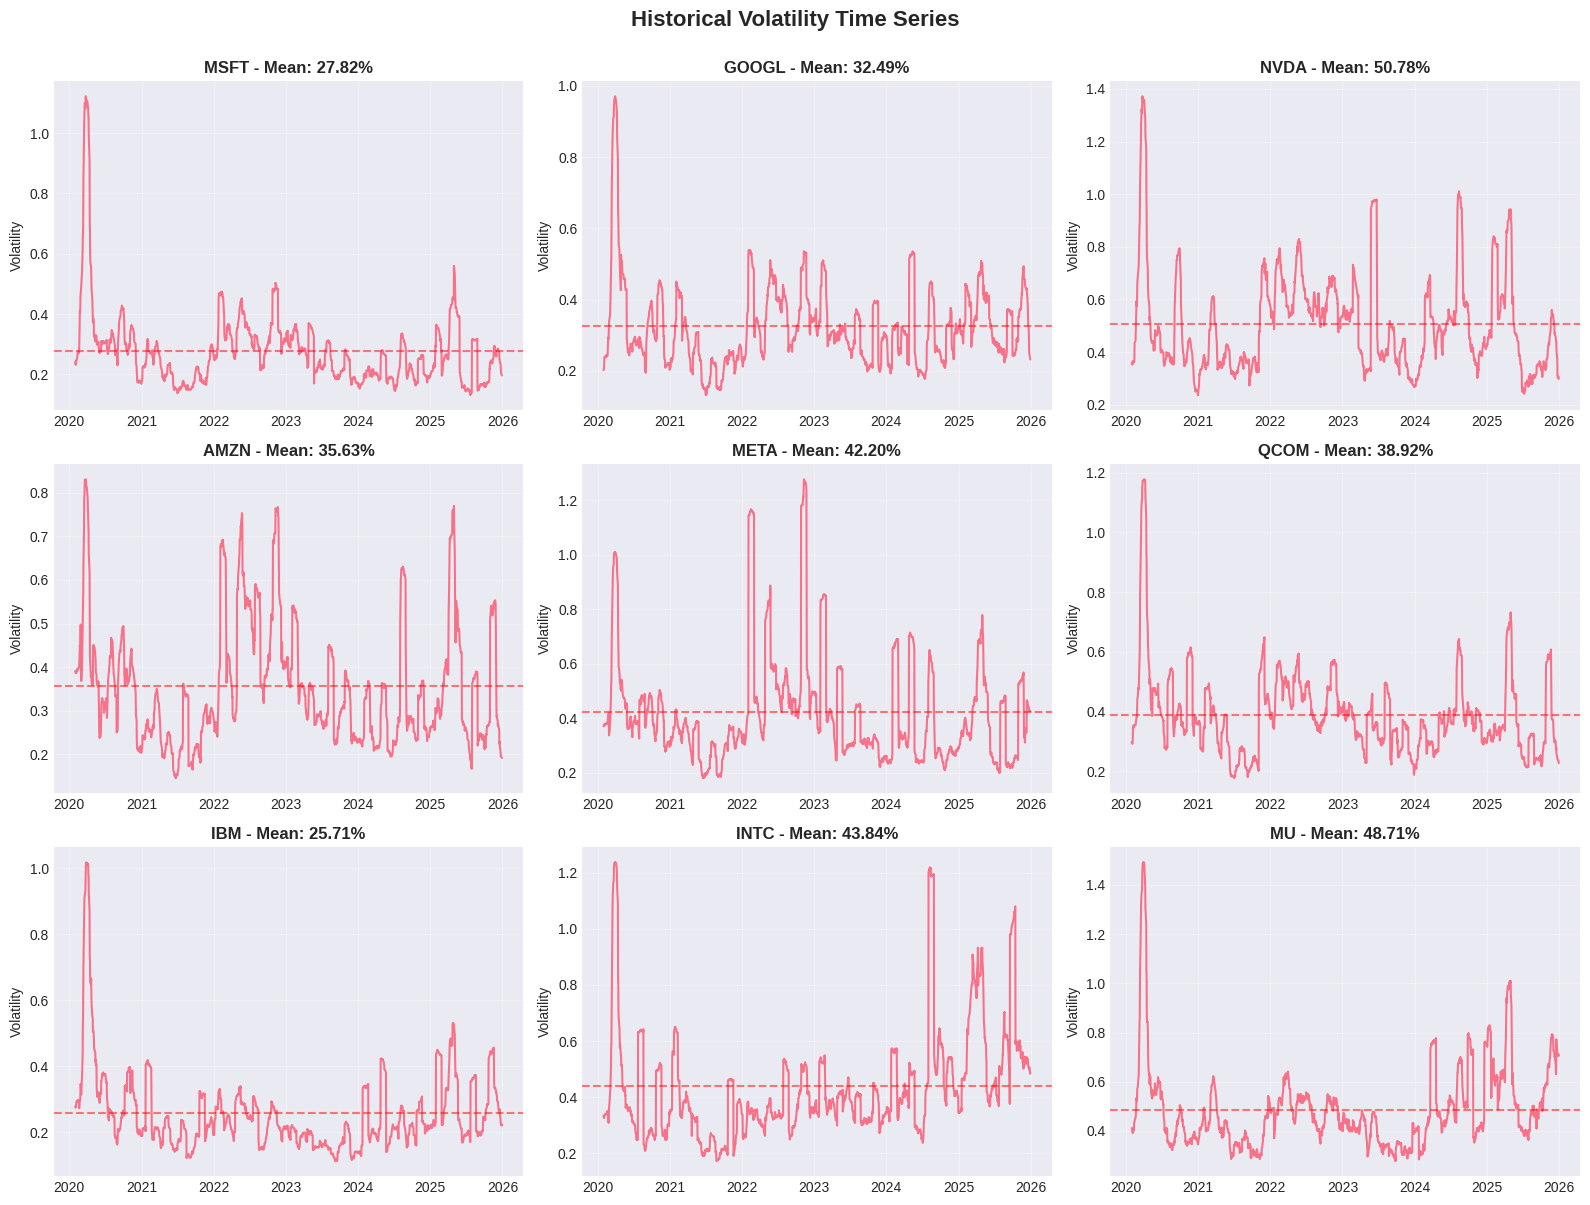

In [12]:
# Visualize volatility time series
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (ticker, vol_series) in enumerate(volatility_df.items()):
    if idx < len(axes):
        axes[idx].plot(vol_series.index, vol_series.values, linewidth=1.5)
        axes[idx].set_title(f'{ticker} - Mean: {vol_series.mean():.2%}', fontweight='bold')
        axes[idx].set_ylabel('Volatility')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axhline(y=vol_series.mean(), color='red', linestyle='--', alpha=0.5)

plt.suptitle('Historical Volatility Time Series', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Step 3: Volatility Clustering

Use K-means++ to cluster assets into low, mid, and high volatility groups.

We focus on the **mid-volatility cluster** as it represents the optimal balance between risk and profit potential.

In [13]:
print("="*80)
print("STEP 3: VOLATILITY CLUSTERING")
print("="*80)

cluster_config = config['clustering']
print(f"\nNumber of clusters: {cluster_config['n_clusters']}")
print(f"Target cluster: Mid-volatility (cluster {cluster_config['target_cluster']})\n")

# Perform clustering
clustering, mid_cluster_members = cluster_assets_by_volatility(
    volatility_df,
    n_clusters=cluster_config['n_clusters'],
    random_state=cluster_config['random_state'],
    target_cluster='mid'
)

STEP 3: VOLATILITY CLUSTERING

Number of clusters: 3
Target cluster: Mid-volatility (cluster 1)


Cluster Statistics:
 cluster_id  n_members  mean_volatility  median_volatility  std_volatility  min_volatility  max_volatility                members cluster_type
          0          3         0.286756           0.278236        0.034666        0.257144        0.324888       MSFT, GOOGL, IBM          Low
          2          4         0.401448           0.405577        0.036425        0.356253        0.438382 AMZN, META, QCOM, INTC          Mid
          1          2         0.497453           0.497453        0.014692        0.487064        0.507841               NVDA, MU         High

Mid-volatility cluster members: ['AMZN', 'META', 'QCOM', 'INTC']


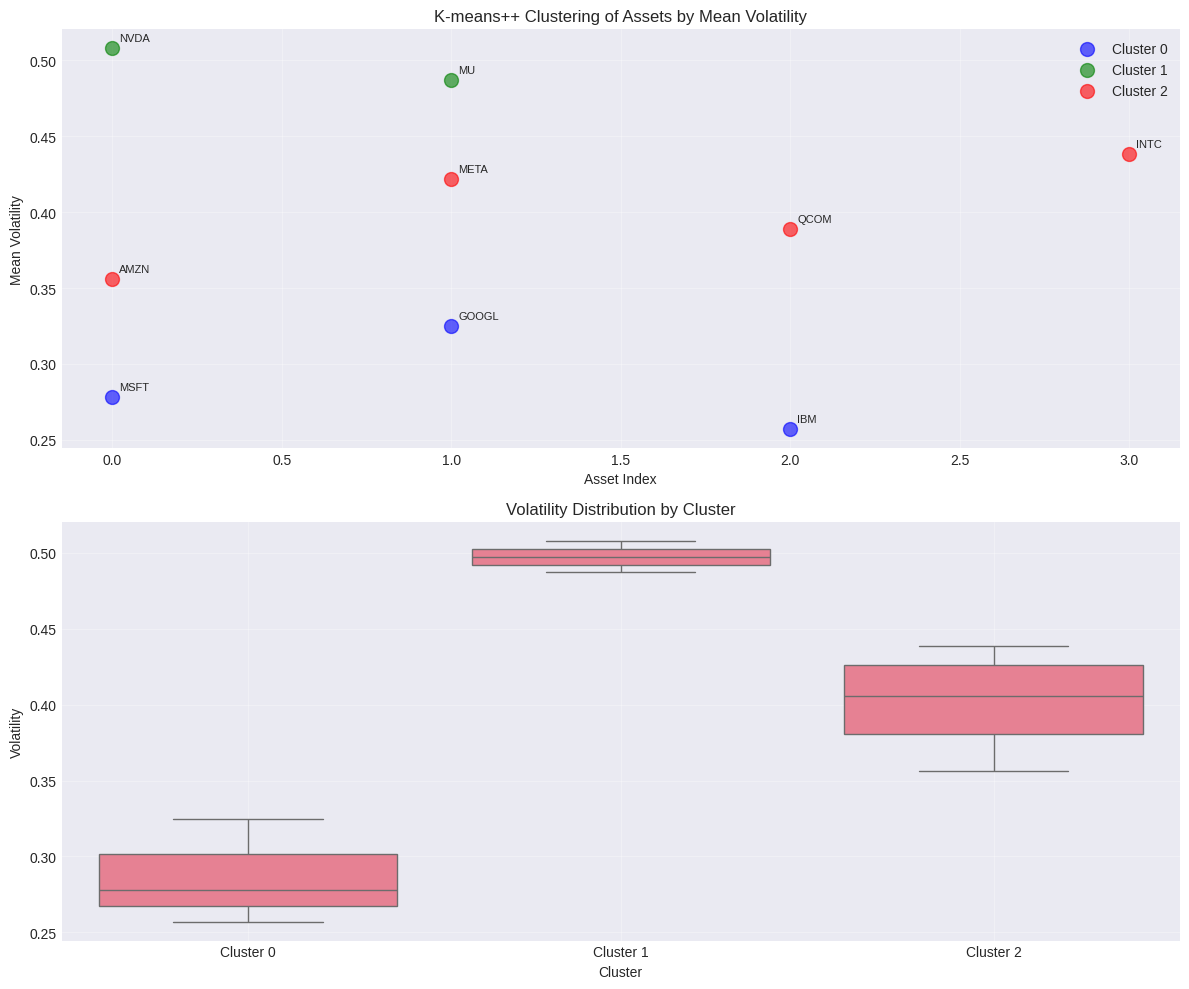

In [14]:
# Visualize clustering results
clustering.plot_clusters(volatility_df)

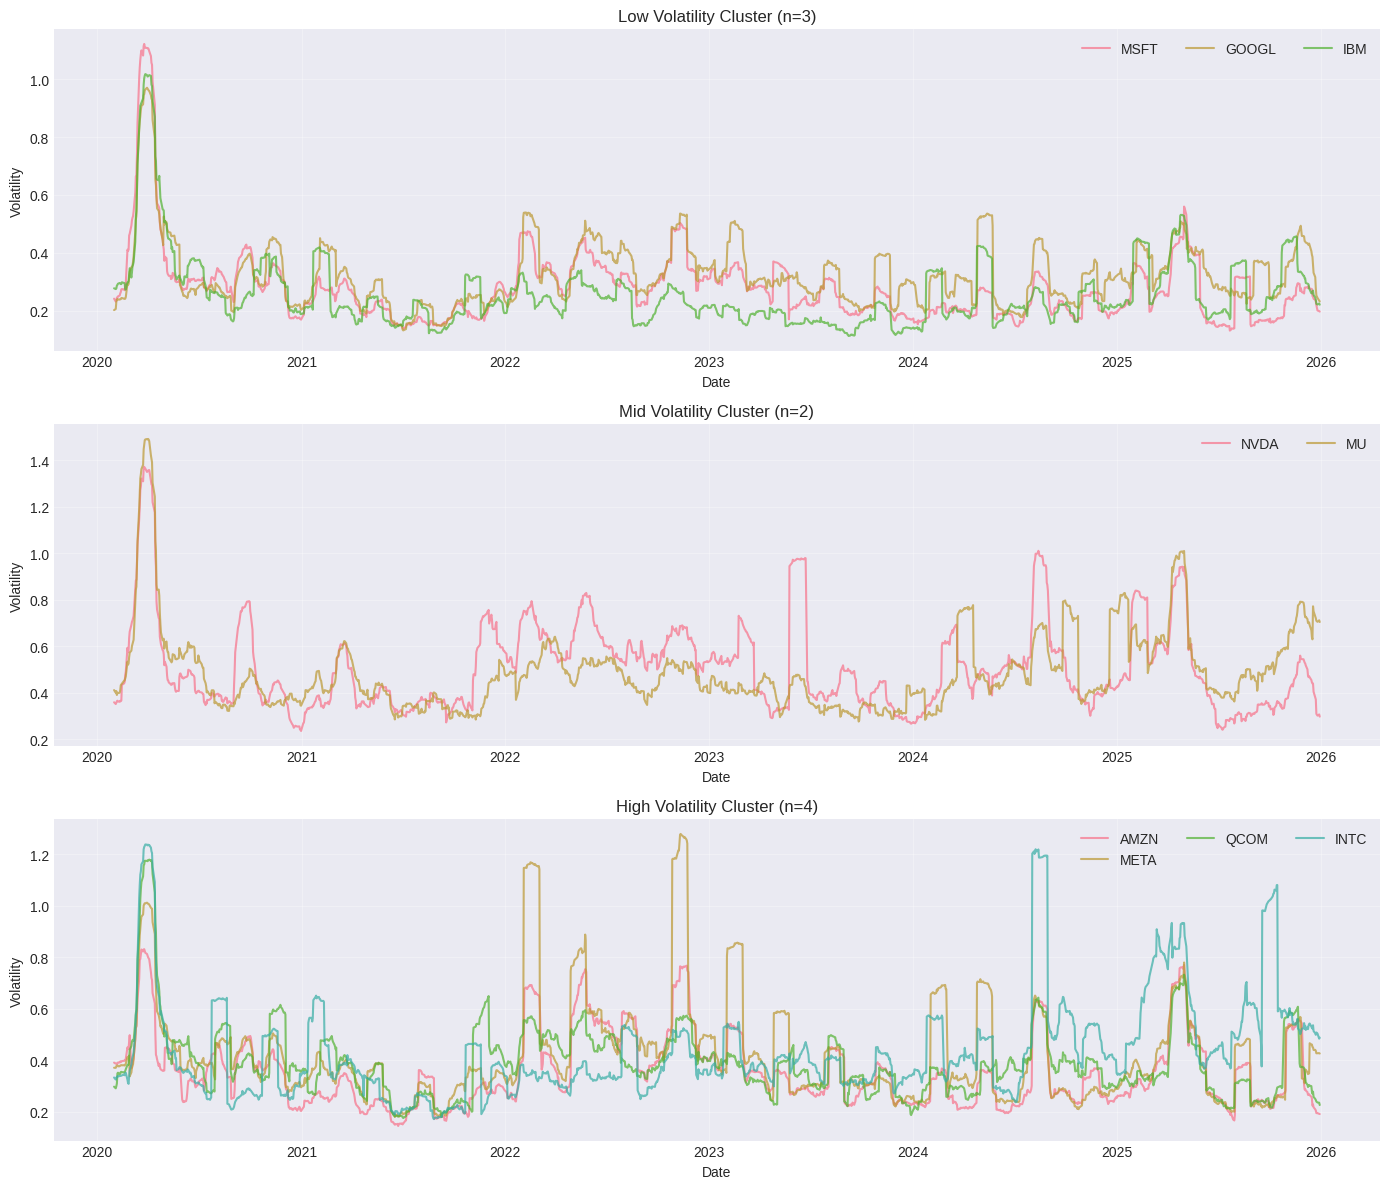

In [15]:
# Visualize time series by cluster
clustering.plot_time_series_by_cluster(volatility_df)

## Step 4: Granger Causality Analysis

Test for predictive relationships between volatility time series in the mid-cluster.

If Stock A's volatility **Granger-causes** Stock B's volatility (A → B), then past values of A's volatility help predict B's volatility beyond B's own past values.

In [16]:
print("="*80)
print("STEP 4: GRANGER CAUSALITY ANALYSIS")
print("="*80)

granger_config = config['granger']
print(f"\nTesting lags: {granger_config['min_lag']} to {granger_config['max_lag']}")
print(f"Optimal lag: {granger_config['optimal_lag']}")
print(f"Significance level: {granger_config['alpha']}")
print(f"\nTesting {len(mid_cluster_members)} assets in mid-cluster...\n")

# Identify trading pairs
trading_pairs, analyzer = identify_trading_pairs(
    volatility_df,
    mid_cluster_members,
    target_lag=granger_config['optimal_lag'],
    significance_level=granger_config['alpha'],
    max_lag=granger_config['max_lag'],
    remove_circular=True
)

if len(trading_pairs) == 0:
    print("\nWARNING: No significant Granger causality relationships found!")
    print("Consider:")
    print("  - Adjusting the significance level")
    print("  - Testing different lag ranges")
    print("  - Using a longer historical period")
else:
    print(f"\nFound {len(trading_pairs)} trading pairs!")

STEP 4: GRANGER CAUSALITY ANALYSIS

Testing lags: 2 to 30
Optimal lag: 5
Significance level: 0.05

Testing 4 assets in mid-cluster...

Testing Granger causality for 4 assets...
Testing pair 10/12...

Found 12 significant causality relationships
Filtered to 4 relationships with lag 5 ± 2
Removed circular relationships: 4 -> 3

Identified Trading Pairs:
predictor target  optimal_lag      p_value  f_statistic  n_significant_lags
     META   QCOM            6 7.033787e-16    14.284894                  30
     INTC   AMZN            6 2.221767e-10     9.600821                  29
     INTC   META            6 2.667570e-06     6.078345                  19

Found 3 trading pairs!


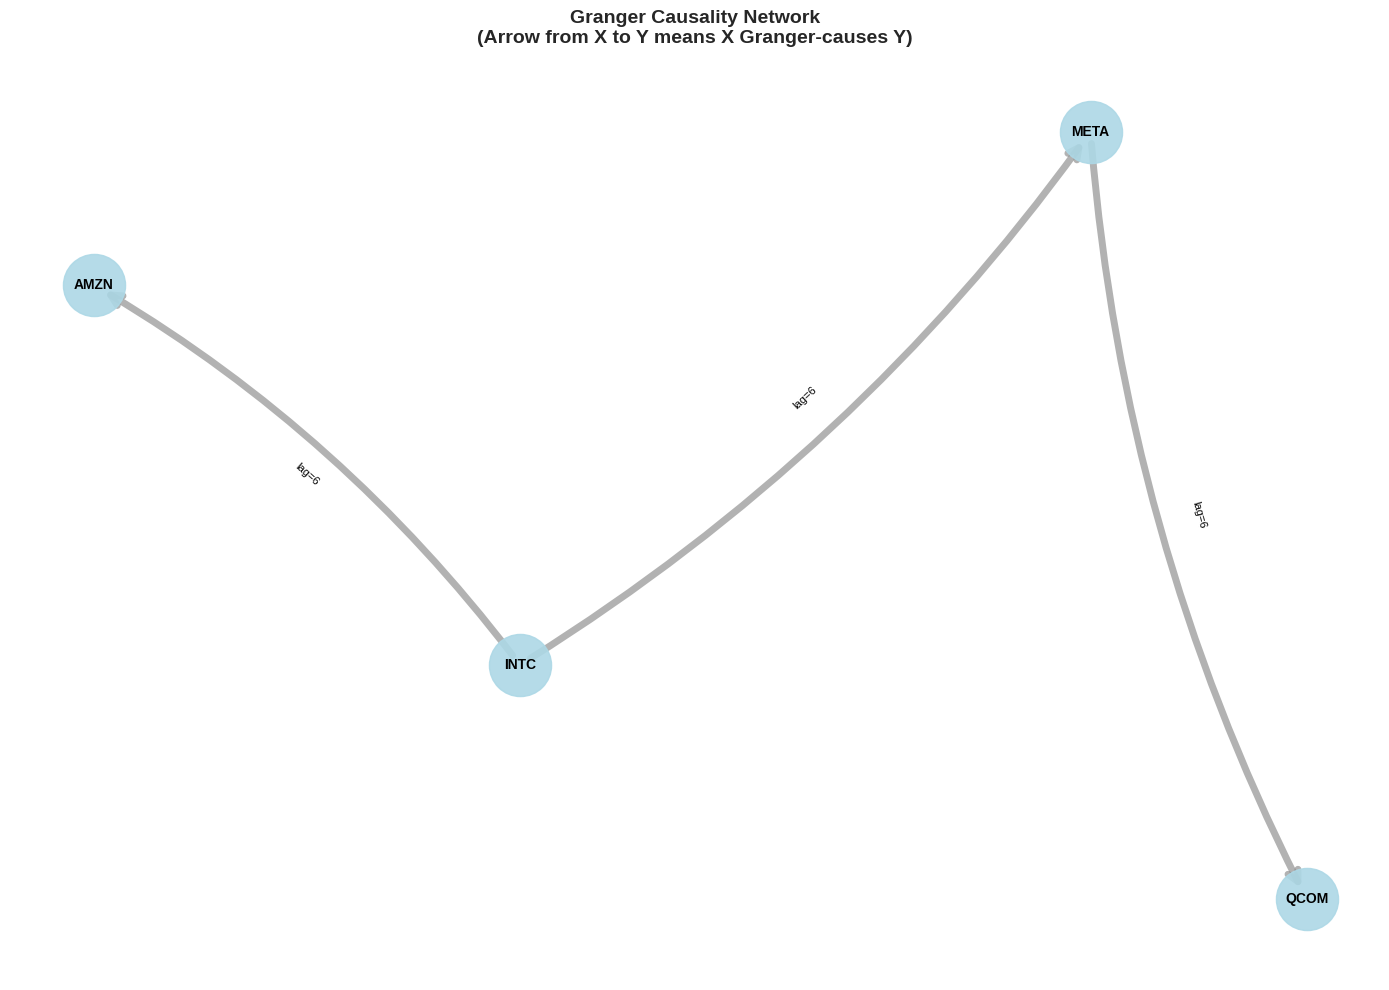

In [17]:
# Visualize causality network
if len(trading_pairs) > 0:
    analyzer.plot_causality_network(trading_pairs, figsize=(14, 10))
else:
    print("No trading pairs to visualize.")

In [18]:
# Display trading pairs details
if len(trading_pairs) > 0:
    print("\nTrading Pairs Details:")
    print("="*80)
    display(trading_pairs)
    
    print("\nInterpretation:")
    for _, row in trading_pairs.iterrows():
        print(f"\n{row['predictor']} -> {row['target']}:")
        print(f"  When {row['predictor']}'s volatility trends UP, BUY {row['target']}")
        print(f"  When {row['predictor']}'s volatility trends DOWN, SELL {row['target']}")
        print(f"  Optimal lag: {row['optimal_lag']} days")
        print(f"  P-value: {row['p_value']:.4f}")


Trading Pairs Details:


,predictor,target,optimal_lag,p_value,f_statistic,n_significant_lags
0,META,QCOM,6,7.033787e-16,14.284894,30
1,INTC,AMZN,6,2.221767e-10,9.600821,29
2,INTC,META,6,2.667570e-06,6.078345,19



Interpretation:

META -> QCOM:
  When META's volatility trends UP, BUY QCOM
  When META's volatility trends DOWN, SELL QCOM
  Optimal lag: 6 days
  P-value: 0.0000

INTC -> AMZN:
  When INTC's volatility trends UP, BUY AMZN
  When INTC's volatility trends DOWN, SELL AMZN
  Optimal lag: 6 days
  P-value: 0.0000

INTC -> META:
  When INTC's volatility trends UP, BUY META
  When INTC's volatility trends DOWN, SELL META
  Optimal lag: 6 days
  P-value: 0.0000


## Step 5: Signal Generation

Generate trading signals using trend-following on the predictor stock's volatility.

In [19]:
if len(trading_pairs) == 0:
    print("Cannot generate signals without trading pairs.")
else:
    print("="*80)
    print("STEP 5: SIGNAL GENERATION")
    print("="*80)
    
    strategy_config = config['strategy']
    print(f"\nStrategy type: VOLTS (Volatility + Price Trend Combined)")
    print(f"Volatility trend method: {strategy_config['trend_method']}")
    print(f"Price trend method: {strategy_config['trend_method']}")
    print(f"Trend parameters: {strategy_config['trend_params']}\n")
    
    print("Signal Logic:")
    print("  - BUY: When predictor volatility ↑ AND target price ↑")
    print("  - SELL: When predictor volatility ↑ AND target price ↓")
    print("  - HOLD: When predictor volatility ↓ (calm period)\n")
    
    # Initialize signal generator
    signal_gen = SignalGenerator(
        trend_method=strategy_config['trend_method'],
        trend_params=strategy_config['trend_params']
    )
    
    # Generate signals for all pairs (now includes price data)
    signals = signal_gen.generate_signals_for_all_pairs(
        volatility_df, 
        trading_pairs,
        data_dict  # Pass price data
    )
    
    # Analyze signals
    stats = SignalAnalyzer.get_signal_statistics(signals)
    print("Signal Statistics:")
    display(stats)

STEP 5: SIGNAL GENERATION

Strategy type: VOLTS (Volatility + Price Trend Combined)
Volatility trend method: sma_crossover
Price trend method: sma_crossover
Trend parameters: {'fast_period': 5, 'slow_period': 20}

Signal Logic:
  - BUY: When predictor volatility ↑ AND target price ↑
  - SELL: When predictor volatility ↑ AND target price ↓
  - HOLD: When predictor volatility ↓ (calm period)

Signal Statistics:


,pair,n_buy,n_sell,n_hold,total_days,n_trades,pct_active
0,META->QCOM,373,351,763,1487,130,48.688635
1,INTC->AMZN,401,343,743,1487,119,50.033625
2,INTC->META,422,322,743,1487,121,50.033625



Plotting signals for META->QCOM...


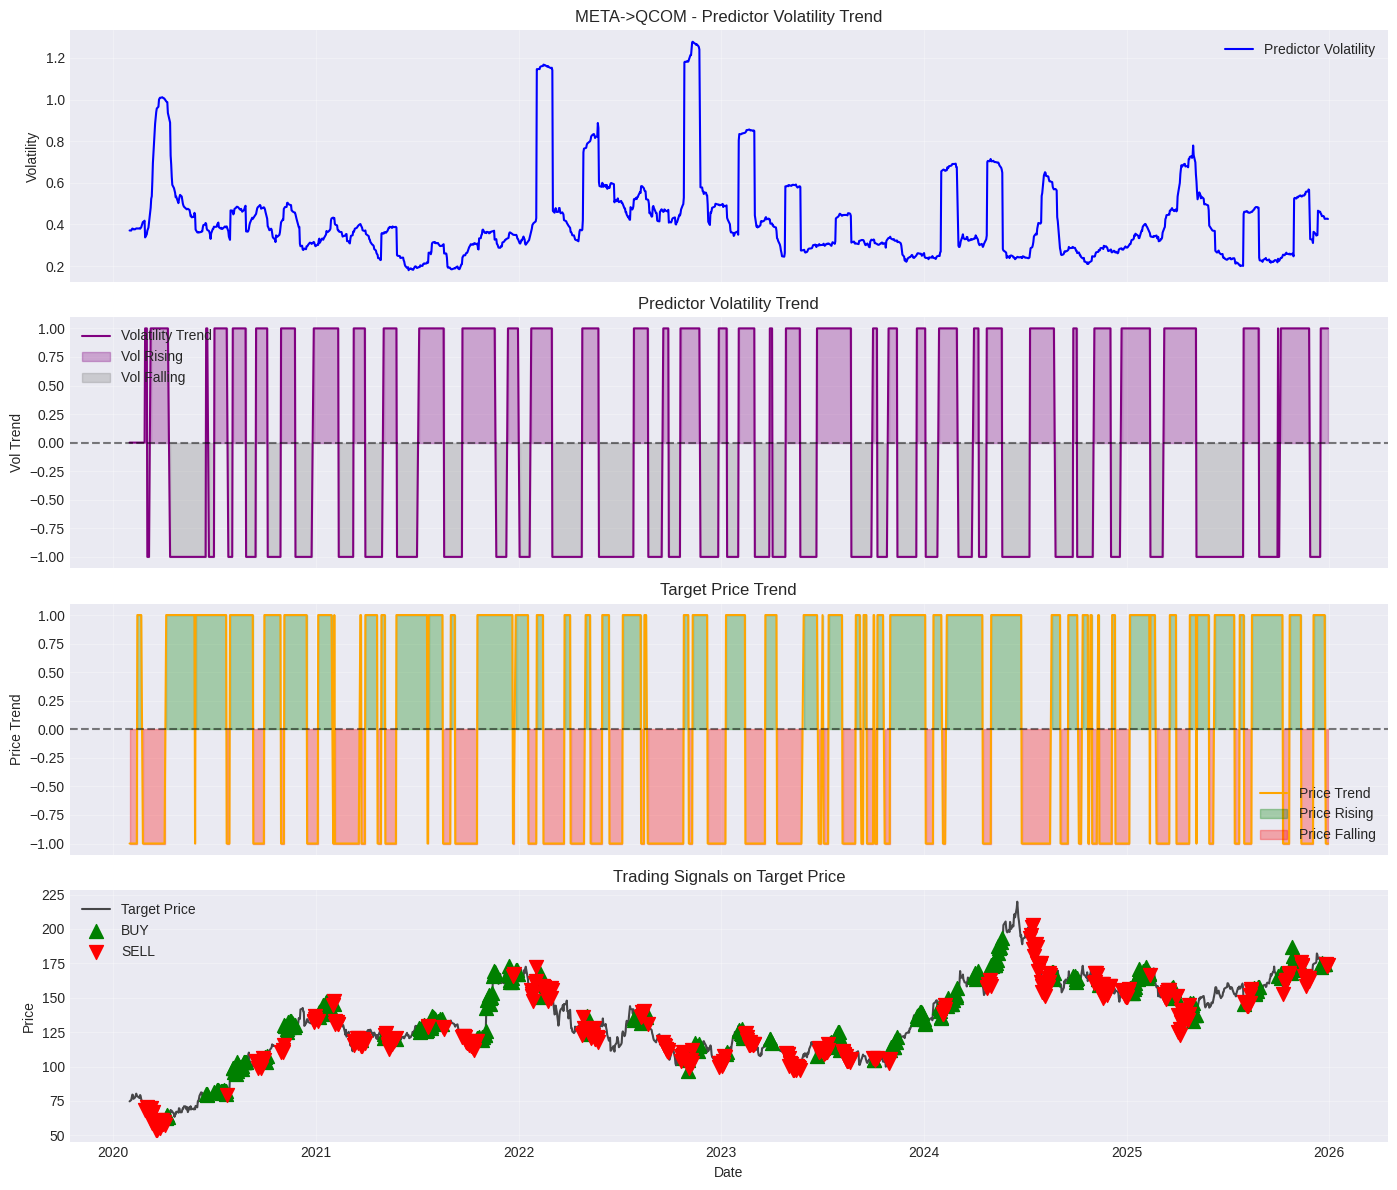


Plotting signals for INTC->AMZN...


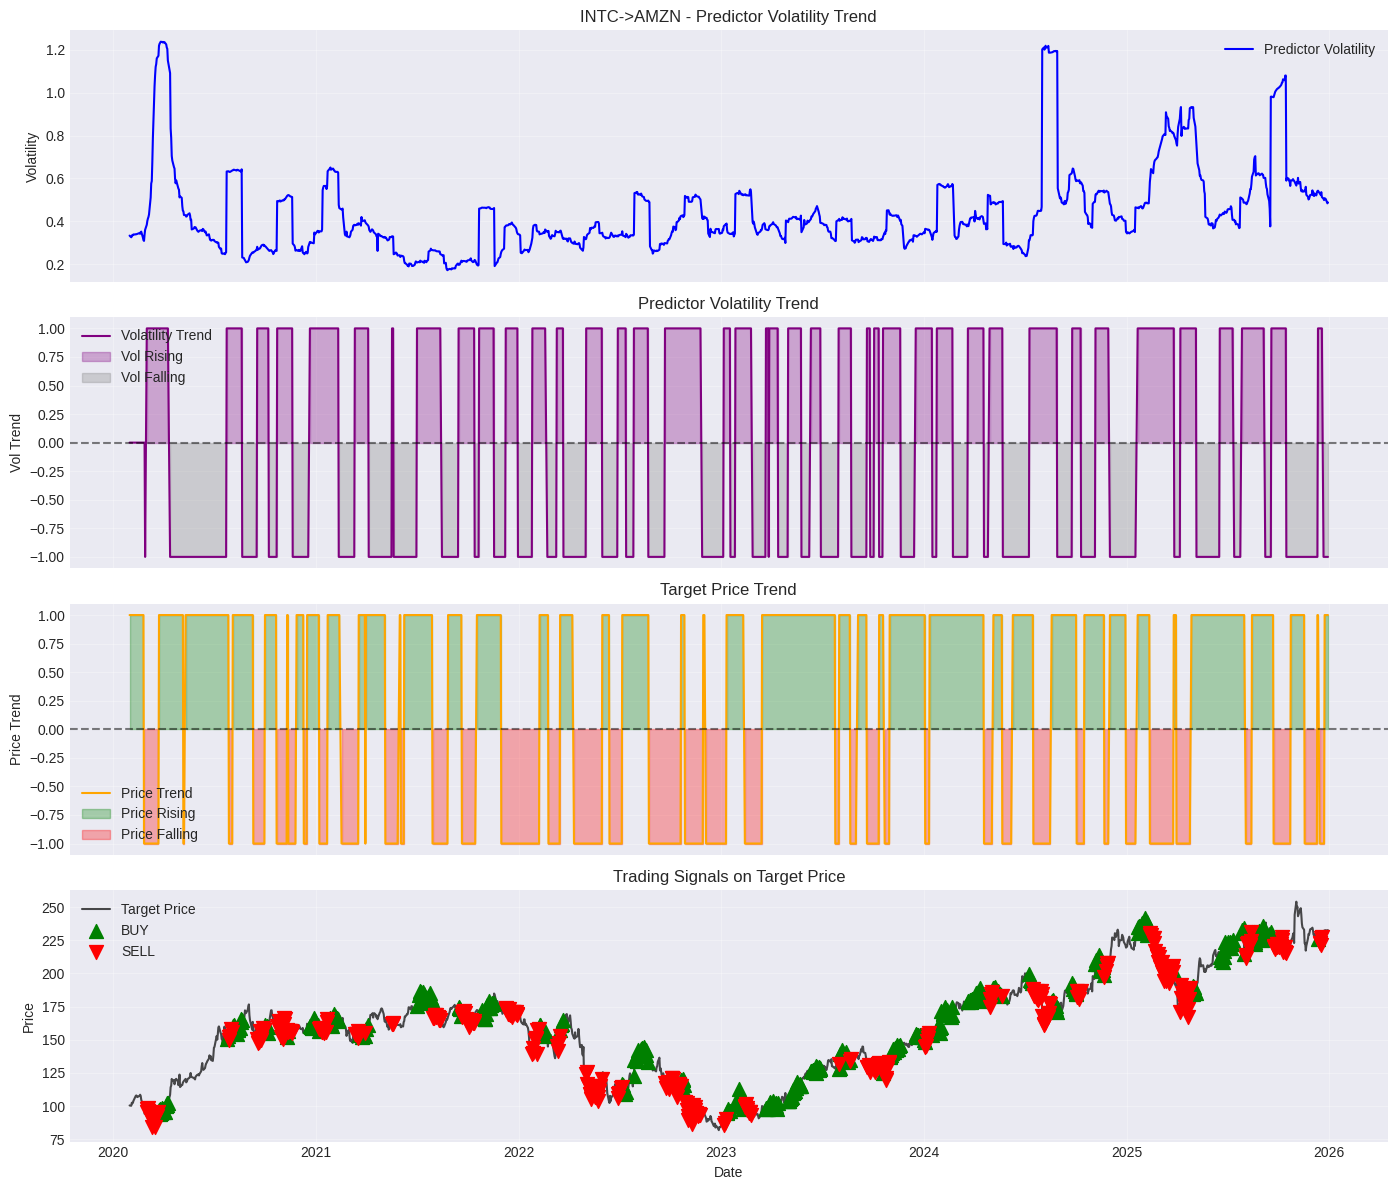


Plotting signals for INTC->META...


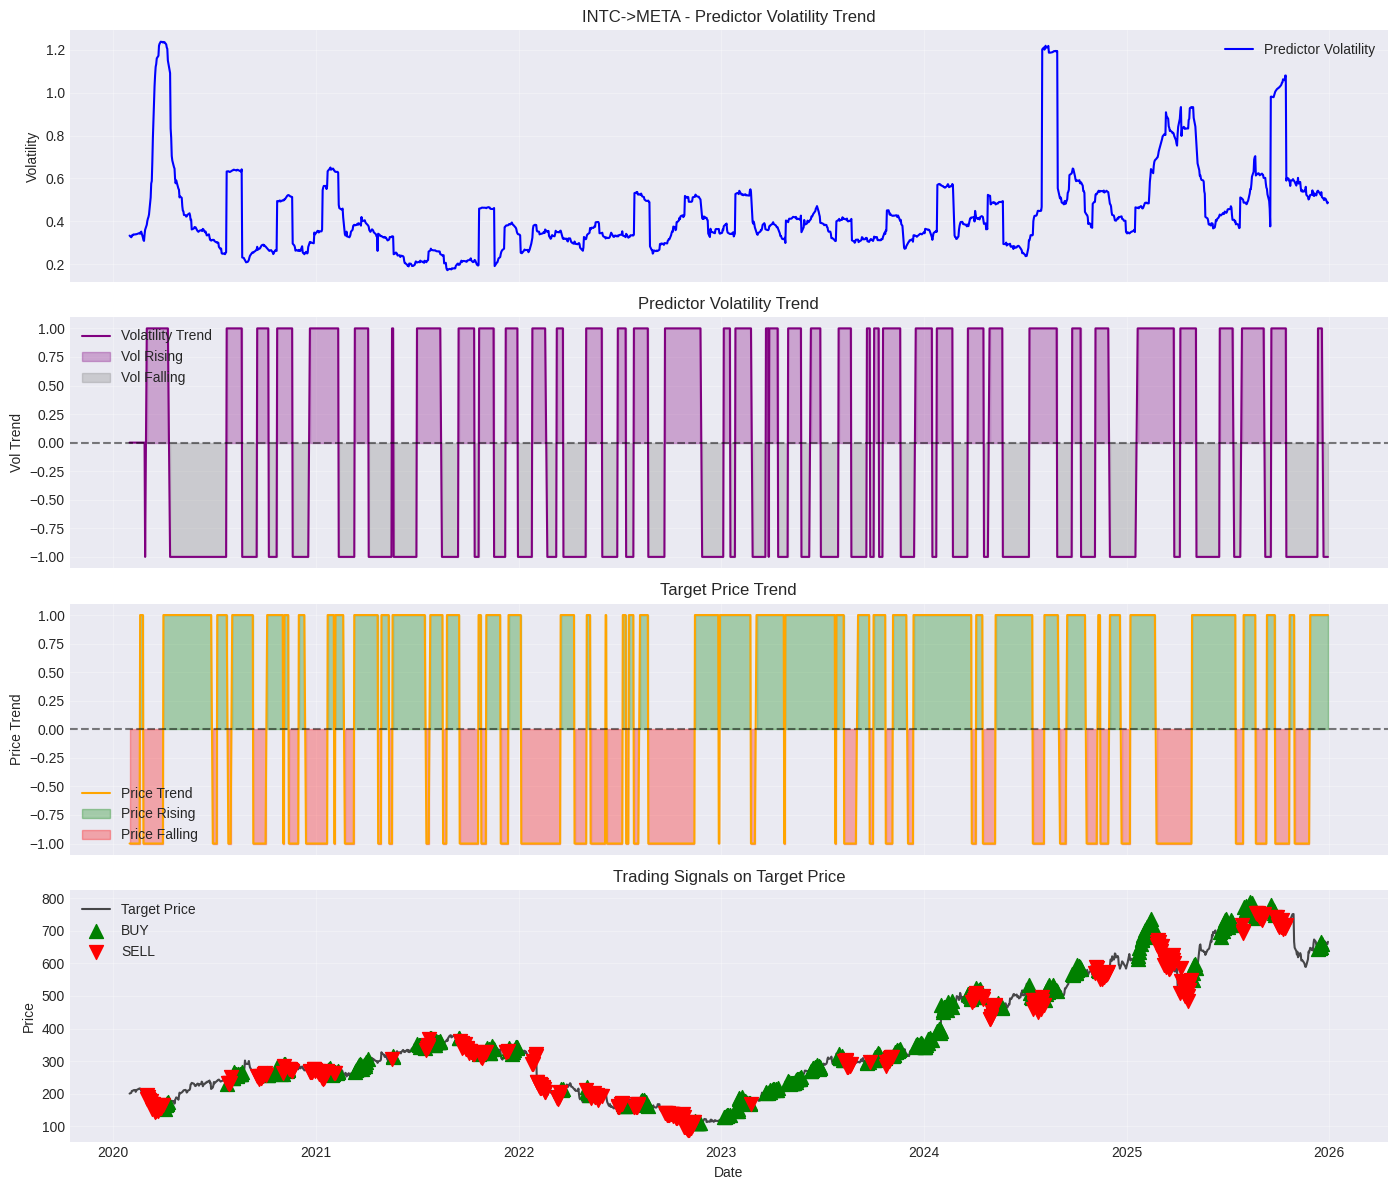

In [20]:
# Visualize signals for each pair
if len(trading_pairs) > 0:
    for pair_name, signals_df in signals.items():
        print(f"\nPlotting signals for {pair_name}...")
        
        target_ticker = pair_name.split('->')[1]
        target_price = data_dict[target_ticker]['Close']
        
        SignalAnalyzer.plot_signals(
            signals_df,
            price_data=target_price,
            title=pair_name
        )
        plt.show()

In [21]:
# DIAGNOSTIC: Check what signals are being generated
if len(trading_pairs) > 0:
    print("SIGNAL DIAGNOSTIC")
    print("="*80)
    
    for pair_name, signals_df in signals.items():
        print(f"\n{pair_name}:")
        print(f"  Total days: {len(signals_df)}")
        print(f"  BUY signals: {(signals_df['signal'] == 1).sum()}")
        print(f"  SELL signals: {(signals_df['signal'] == -1).sum()}")
        print(f"  HOLD signals: {(signals_df['signal'] == 0).sum()}")
        print(f"  % Time in market: {((signals_df['signal'] != 0).sum() / len(signals_df) * 100):.1f}%")
        
        # Check trend alignment
        both_up = ((signals_df['vol_trend'] == 1) & (signals_df['price_trend'] == 1)).sum()
        both_down = ((signals_df['vol_trend'] == -1) & (signals_df['price_trend'] == -1)).sum()
        vol_up_price_down = ((signals_df['vol_trend'] == 1) & (signals_df['price_trend'] == -1)).sum()
        vol_down_price_up = ((signals_df['vol_trend'] == -1) & (signals_df['price_trend'] == 1)).sum()
        
        print(f"  Vol↑ & Price↑: {both_up} days")
        print(f"  Vol↑ & Price↓: {vol_up_price_down} days")
        print(f"  Vol↓ & Price↑: {vol_down_price_up} days")
        print(f"  Vol↓ & Price↓: {both_down} days")
        
        # Show a sample of recent signals
        print(f"\n  Last 10 signals:")
        recent = signals_df[['vol_trend', 'price_trend', 'signal']].tail(10)
        for date, row in recent.iterrows():
            signal_name = "BUY" if row['signal'] == 1 else ("SELL" if row['signal'] == -1 else "HOLD")
            print(f"    {date.date()}: Vol={'↑' if row['vol_trend']==1 else '↓'} Price={'↑' if row['price_trend']==1 else '↓'} → {signal_name}")

SIGNAL DIAGNOSTIC

META->QCOM:
  Total days: 1487
  BUY signals: 373
  SELL signals: 351
  HOLD signals: 763
  % Time in market: 48.7%
  Vol↑ & Price↑: 373 days
  Vol↑ & Price↓: 351 days
  Vol↓ & Price↑: 458 days
  Vol↓ & Price↓: 286 days

  Last 10 signals:
    2025-12-16: Vol=↓ Price=↑ → HOLD
    2025-12-17: Vol=↑ Price=↑ → BUY
    2025-12-18: Vol=↑ Price=↑ → BUY
    2025-12-19: Vol=↑ Price=↑ → BUY
    2025-12-22: Vol=↑ Price=↑ → BUY
    2025-12-23: Vol=↑ Price=↑ → BUY
    2025-12-24: Vol=↑ Price=↑ → BUY
    2025-12-26: Vol=↑ Price=↓ → SELL
    2025-12-29: Vol=↑ Price=↓ → SELL
    2025-12-30: Vol=↑ Price=↓ → SELL

INTC->AMZN:
  Total days: 1487
  BUY signals: 401
  SELL signals: 343
  HOLD signals: 743
  % Time in market: 50.0%
  Vol↑ & Price↑: 401 days
  Vol↑ & Price↓: 343 days
  Vol↓ & Price↑: 466 days
  Vol↓ & Price↓: 258 days

  Last 10 signals:
    2025-12-16: Vol=↑ Price=↓ → SELL
    2025-12-17: Vol=↑ Price=↓ → SELL
    2025-12-18: Vol=↑ Price=↓ → SELL
    2025-12-19: Vol=↑ Pri

### Try Simplified Long-Only Strategy

The original strategy might be failing due to shorting issues. Let's try a simpler approach:
- **LONG ONLY** (no short selling)
- Enter when volatility ↑ AND price ↑
- Exit otherwise

In [22]:
from signal_generator_simple import SimpleVoltsSignalGenerator

# Use simplified long-only signal generator
strategy_config = config['strategy']
simple_signal_gen = SimpleVoltsSignalGenerator(
    trend_method=strategy_config['trend_method'],
    trend_params=strategy_config['trend_params']
)

print("Generating LONG-ONLY signals for trading pairs...")
simple_signals_dict = simple_signal_gen.generate_signals_for_all_pairs(
    volatility_df,  # First argument
    trading_pairs,  # Second argument
    data_dict       # Third argument
)

# Run backtest with simplified signals
print("\n" + "="*80)
print("Running backtests with LONG-ONLY strategy...")
print("="*80)

simple_results = {}
for _, row in trading_pairs.iterrows():
    predictor = row['predictor']
    target = row['target']
    pair_name = f"{predictor}->{target}"
    signals_df = simple_signals_dict[pair_name]
    
    print(f"\n{'='*60}")
    print(f"Backtesting: {pair_name}")
    print(f"{'='*60}")
    
    backtester = VoltBacktester(
        initial_capital_per_pair=strategy_config['initial_capital'],
        commission=strategy_config['commission'],
        slippage=strategy_config['slippage'],
        position_size_pct=strategy_config['position_size_pct']
    )
    
    # Create single-pair signals dict for backtester
    single_pair_signals = {pair_name: signals_df}
    single_pair_data = {target: data_dict[target]}
    
    result = backtester.run_backtest(
        single_pair_data,
        single_pair_signals,
        start_date=pd.Timestamp(config['backtest']['start_date']),
        end_date=pd.Timestamp(config['backtest']['end_date'])
    )
    
    simple_results[pair_name] = result['pair_results'][pair_name]['metrics']
    
    print(f"\nResults for {pair_name}:")
    print(f"  Total Return: {simple_results[pair_name]['total_return']:.2f}")
    print(f"  Total Return %: {simple_results[pair_name]['total_return_pct']:.2f}%")
    print(f"  Sharpe Ratio: {simple_results[pair_name]['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {simple_results[pair_name]['win_rate']:.1f}%")
    print(f"  Total Trades: {simple_results[pair_name]['n_trades']}")
    print(f"  Max Drawdown: {simple_results[pair_name]['max_drawdown']:.2f}%")

# Aggregate results
total_return_pct = np.mean([r['total_return_pct'] for r in simple_results.values()])
avg_sharpe = np.mean([r['sharpe_ratio'] for r in simple_results.values()])
total_trades = sum([r['n_trades'] for r in simple_results.values()])
avg_win_rate = np.mean([r['win_rate'] for r in simple_results.values()])

print("\n" + "="*80)
print("AGGREGATE RESULTS (Long-Only)")
print("="*80)
print(f"Average Total Return: {total_return_pct:.2f}%")
print(f"Average Sharpe Ratio: {avg_sharpe:.2f}")
print(f"Average Win Rate: {avg_win_rate:.1f}%")
print(f"Total Trades: {total_trades}")
print("\nCompare to original strategy results above...")

Generating LONG-ONLY signals for trading pairs...

Running backtests with LONG-ONLY strategy...

Backtesting: META->QCOM

Results for META->QCOM:
  Total Return: -858.55
  Total Return %: -85.85%
  Sharpe Ratio: -1.76
  Win Rate: 12.5%
  Total Trades: 32
  Max Drawdown: 86.16%

Backtesting: INTC->AMZN

Results for INTC->AMZN:
  Total Return: -803.85
  Total Return %: -80.38%
  Sharpe Ratio: -1.64
  Win Rate: 25.7%
  Total Trades: 35
  Max Drawdown: 82.06%

Backtesting: INTC->META

Results for INTC->META:
  Total Return: -741.74
  Total Return %: -74.17%
  Sharpe Ratio: -1.59
  Win Rate: 19.2%
  Total Trades: 26
  Max Drawdown: 76.93%

AGGREGATE RESULTS (Long-Only)
Average Total Return: -80.14%
Average Sharpe Ratio: -1.66
Average Win Rate: 19.1%
Total Trades: 93

Compare to original strategy results above...


#### Diagnostic: Check Long-Only Signals

Let's inspect what signals the simplified generator produced:

In [ ]:
print("LONG-ONLY SIGNAL DIAGNOSTIC")
print("="*80)

for pair_name, signals_df in simple_signals_dict.items():
    print(f"\n{pair_name}:")
    print(f"  Total days: {len(signals_df)}")
    print(f"  BUY signals: {(signals_df['signal'] == 1).sum()}")
    print(f"  HOLD signals: {(signals_df['signal'] == 0).sum()}")
    print(f"  % Time in market: {((signals_df['signal'] == 1).sum() / len(signals_df) * 100):.1f}%")
    
    # Check if there are any columns showing trends
    if 'vol_trend' in signals_df.columns and 'price_trend' in signals_df.columns:
        both_up = ((signals_df['vol_trend'] == 1) & (signals_df['price_trend'] == 1)).sum()
        print(f"  Days when Vol↑ & Price↑: {both_up}")
        print(f"  Days converted to BUY: {(signals_df['signal'] == 1).sum()}")
    
    # Show last 10 signals
    print(f"\n  Last 10 signals:")
    recent = signals_df[['signal']].tail(10)
    for date, row in recent.iterrows():
        signal_name = "BUY" if row['signal'] == 1 else "HOLD"
        print(f"    {date.date()}: {signal_name}")
    
    # Check for any BUY signals at all
    if (signals_df['signal'] == 1).sum() == 0:
        print(f"\n  WARNING: No BUY signals generated! This explains 0 trades.")

LONG-ONLY SIGNAL DIAGNOSTIC

META->QCOM:
  Total days: 1487
  BUY signals: 373
  HOLD signals: 1114
  % Time in market: 25.1%
  Days when Vol↑ & Price↑: 373
  Days converted to BUY: 373

  Last 10 signals:
    2025-12-16: HOLD
    2025-12-17: BUY
    2025-12-18: BUY
    2025-12-19: BUY
    2025-12-22: BUY
    2025-12-23: BUY
    2025-12-24: BUY
    2025-12-26: HOLD
    2025-12-29: HOLD
    2025-12-30: HOLD

INTC->AMZN:
  Total days: 1487
  BUY signals: 401
  HOLD signals: 1086
  % Time in market: 27.0%
  Days when Vol↑ & Price↑: 401
  Days converted to BUY: 401

  Last 10 signals:
    2025-12-16: HOLD
    2025-12-17: HOLD
    2025-12-18: HOLD
    2025-12-19: HOLD
    2025-12-22: HOLD
    2025-12-23: HOLD
    2025-12-24: HOLD
    2025-12-26: HOLD
    2025-12-29: HOLD
    2025-12-30: HOLD

INTC->META:
  Total days: 1487
  BUY signals: 422
  HOLD signals: 1065
  % Time in market: 28.4%
  Days when Vol↑ & Price↑: 422
  Days converted to BUY: 422

  Last 10 signals:
    2025-12-16: BUY
    

#### Compare Original vs Long-Only Signals

In [24]:
print("COMPARISON: Original vs Long-Only")
print("="*80)

for pair_name in signals.keys():
    original_signals = signals[pair_name]
    longonly_signals = simple_signals_dict[pair_name]
    
    print(f"\n{pair_name}:")
    print(f"  Original Strategy:")
    print(f"    BUY:  {(original_signals['signal'] == 1).sum()}")
    print(f"    SELL: {(original_signals['signal'] == -1).sum()}")
    print(f"    HOLD: {(original_signals['signal'] == 0).sum()}")
    
    print(f"  Long-Only Strategy:")
    print(f"    BUY:  {(longonly_signals['signal'] == 1).sum()}")
    print(f"    HOLD: {(longonly_signals['signal'] == 0).sum()}")
    
    # The long-only BUY should match "Vol↑ & Price↑" from original
    both_up_original = ((original_signals['vol_trend'] == 1) & (original_signals['price_trend'] == 1)).sum()
    print(f"\n  Original had {both_up_original} days with Vol↑ & Price↑")
    print(f"  Long-only has {(longonly_signals['signal'] == 1).sum()} BUY signals")
    
    if both_up_original != (longonly_signals['signal'] == 1).sum():
        print(f"  ⚠️  MISMATCH! Should be equal.")
    
    # Show where the discrepancy is
    if both_up_original == 0:
        print(f"  ⚠️  No days where BOTH vol and price are rising together!")
        print(f"      This market condition doesn't support this strategy.")

COMPARISON: Original vs Long-Only

META->QCOM:
  Original Strategy:
    BUY:  373
    SELL: 351
    HOLD: 763
  Long-Only Strategy:
    BUY:  373
    HOLD: 1114

  Original had 373 days with Vol↑ & Price↑
  Long-only has 373 BUY signals

INTC->AMZN:
  Original Strategy:
    BUY:  401
    SELL: 343
    HOLD: 743
  Long-Only Strategy:
    BUY:  401
    HOLD: 1086

  Original had 401 days with Vol↑ & Price↑
  Long-only has 401 BUY signals

INTC->META:
  Original Strategy:
    BUY:  422
    SELL: 322
    HOLD: 743
  Long-Only Strategy:
    BUY:  422
    HOLD: 1065

  Original had 422 days with Vol↑ & Price↑
  Long-only has 422 BUY signals


### Alternative: Try Inverted Signals

If win rate is extremely low (<30%), signals might be inverted. Let's test by reversing BUY ↔ SELL:

In [25]:
# Create inverted signals (BUY → SELL, SELL → BUY)
inverted_signals_dict = {}
for pair_name, signals_df in signals.items():
    inverted = signals_df.copy()
    inverted['signal'] = signals_df['signal'].map({1: -1, -1: 1, 0: 0})
    inverted_signals_dict[pair_name] = inverted

print("Testing INVERTED signals (BUY ↔ SELL)...")
print("If this performs better, our logic is backwards!\n")

inverted_results = {}
for _, row in trading_pairs.iterrows():
    predictor = row['predictor']
    target = row['target']
    pair_name = f"{predictor}->{target}"
    signals_df = inverted_signals_dict[pair_name]
    
    backtester = VoltBacktester(
        initial_capital_per_pair=strategy_config['initial_capital'],
        commission=strategy_config['commission'],
        slippage=strategy_config['slippage'],
        position_size_pct=strategy_config['position_size_pct']
    )
    
    # Create single-pair signals dict for backtester
    single_pair_signals = {pair_name: signals_df}
    single_pair_data = {target: data_dict[target]}
    
    result = backtester.run_backtest(
        single_pair_data,
        single_pair_signals,
        start_date=pd.Timestamp(config['backtest']['start_date']),
        end_date=pd.Timestamp(config['backtest']['end_date'])
    )
    
    inverted_results[pair_name] = result['pair_results'][pair_name]['metrics']
    
    print(f"{pair_name}: {inverted_results[pair_name]['total_return_pct']:.2f}% return, {inverted_results[pair_name]['win_rate']:.1f}% win rate")

# Aggregate
inv_total_return = np.mean([r['total_return_pct'] for r in inverted_results.values()])
inv_avg_sharpe = np.mean([r['sharpe_ratio'] for r in inverted_results.values()])
inv_avg_win_rate = np.mean([r['win_rate'] for r in inverted_results.values()])

print("\n" + "="*80)
print(f"INVERTED - Avg Return: {inv_total_return:.2f}%, Avg Win Rate: {inv_avg_win_rate:.1f}%")
print(f"ORIGINAL - Avg Return: {total_return_pct:.2f}%, Avg Win Rate: {avg_win_rate:.1f}%")
print("="*80)

if inv_total_return > total_return_pct:
    print("\n INVERTED signals perform BETTER! Logic needs to be reversed.")
else:
    print("\n✓ Original signals are correct direction.")

Testing INVERTED signals (BUY ↔ SELL)...
If this performs better, our logic is backwards!

META->QCOM: -90.42% return, 22.2% win rate
INTC->AMZN: -91.50% return, 12.5% win rate
INTC->META: -88.57% return, 25.9% win rate

INVERTED - Avg Return: -90.16%, Avg Win Rate: 20.2%
ORIGINAL - Avg Return: -80.14%, Avg Win Rate: 19.1%

✓ Original signals are correct direction.


### Diagnosis: Check Signal Timing

Low win rates often mean signals are too slow (lagging). Let's check signal timing relative to actual price moves:

In [26]:
# Analyze signal timing for one pair
if len(trading_pairs) > 0:
    # Get the first pair
    first_pair = trading_pairs.iloc[0]
    predictor = first_pair['predictor']
    target = first_pair['target']
    pair_name = f"{predictor}->{target}"
    
    signals_df = signals[pair_name]
    target_ticker = target
    price_data = data_dict[target_ticker]['Close']
    
    # Get BUY signals only
    buy_signals = signals_df[signals_df['signal'] == 1].copy()
    
    if len(buy_signals) > 0:
        print(f"Analyzing {len(buy_signals)} BUY signals for {pair_name}\n")
        
        # Check what happens AFTER each buy signal
        forward_returns = []
        for idx in buy_signals.index[:10]:  # Check first 10 signals
            if idx in price_data.index:
                buy_price = price_data.loc[idx]
                
                # Look ahead 5 days
                future_idx = price_data.index.get_loc(idx)
                if future_idx + 5 < len(price_data):
                    future_price = price_data.iloc[future_idx + 5]
                    ret_5d = (future_price - buy_price) / buy_price
                    forward_returns.append(ret_5d)
                    
                    print(f"Signal on {idx.date()}: Buy at ${buy_price:.2f}")
                    print(f"  5-day later: ${future_price:.2f} ({ret_5d:+.2%})")
                    print()
        
        if forward_returns:
            avg_forward_return = np.mean(forward_returns)
            print(f"\nAverage 5-day forward return after BUY signals: {avg_forward_return:+.2%}")
            
            if avg_forward_return < 0:
                print("⚠️  Negative forward returns suggest signals are LATE or INVERTED")
            else:
                print("✓ Positive forward returns suggest signal timing is reasonable")
    else:
        print(f"No BUY signals generated for {pair_name}!")
else:
    print("No trading pairs available for analysis.")

Analyzing 373 BUY signals for META->QCOM

Signal on 2020-04-06: Buy at $62.61
  5-day later: $68.43 (+9.30%)

Signal on 2020-04-07: Buy at $64.18
  5-day later: $67.06 (+4.48%)

Signal on 2020-04-08: Buy at $64.71
  5-day later: $67.82 (+4.80%)

Signal on 2020-04-09: Buy at $63.17
  5-day later: $67.22 (+6.41%)

Signal on 2020-06-17: Buy at $79.98
  5-day later: $79.27 (-0.89%)

Signal on 2020-06-18: Buy at $79.96
  5-day later: $79.11 (-1.07%)

Signal on 2020-06-19: Buy at $78.98
  5-day later: $78.27 (-0.89%)

Signal on 2020-07-02: Buy at $81.70
  5-day later: $82.27 (+0.70%)

Signal on 2020-07-06: Buy at $82.63
  5-day later: $81.22 (-1.71%)

Signal on 2020-07-07: Buy at $81.94
  5-day later: $82.15 (+0.26%)


Average 5-day forward return after BUY signals: +2.14%
✓ Positive forward returns suggest signal timing is reasonable


## Step 6: Backtesting

Evaluate strategy performance with realistic transaction costs and position sizing.

In [27]:
if len(trading_pairs) == 0:
    print("Cannot run backtest without trading pairs.")
else:
    print("="*80)
    print("STEP 6: BACKTESTING")
    print("="*80)
    
    backtest_config = config['backtest']
    strategy_config = config['strategy']
    
    print(f"\nBacktest period: {backtest_config['start_date']} to {backtest_config['end_date']}")
    print(f"Initial capital per pair: ${strategy_config['initial_capital']}")
    print(f"Total capital: ${strategy_config['initial_capital'] * len(trading_pairs)}")
    print(f"Commission: ${strategy_config['commission']} per trade")
    print(f"Slippage: {strategy_config['slippage']:.2%}\n")
    
    # Initialize backtester
    backtester = VoltBacktester(
        initial_capital_per_pair=strategy_config['initial_capital'],
        commission=strategy_config['commission'],
        slippage=strategy_config['slippage'],
        position_size_pct=strategy_config['position_size_pct']
    )
    
    # Run backtest
    results = backtester.run_backtest(
        data_dict,
        signals,
        start_date=pd.Timestamp(backtest_config['start_date']),
        end_date=pd.Timestamp(backtest_config['end_date'])
    )
    
    print("\nBacktest completed!")

STEP 6: BACKTESTING

Backtest period: 2020-01-01 to 2025-12-31
Initial capital per pair: $1000
Total capital: $3000
Commission: $9.0 per trade
Slippage: 0.05%


Backtest completed!


## Results Analysis

In [28]:
# Print detailed results
if len(trading_pairs) > 0:
    backtester.print_results()


VOLTS STRATEGY BACKTEST RESULTS

AGGREGATED PERFORMANCE:
Total Return: $-2693.65 (-89.79%)
Final Value: $306.35
Number of Trades: 94
Win Rate: 17.02%
Profit Factor: 0.23
Max Drawdown: 90.89%
Sharpe Ratio: -2.21
Sortino Ratio: -1.51
Calmar Ratio: -0.35

--------------------------------------------------------------------------------
PER-PAIR PERFORMANCE:
--------------------------------------------------------------------------------

META->QCOM:
  Return: $-906.17 (-90.62%)
  Trades: 27 | Wins: 4 | Losses: 23 | Win Rate: 14.8%
  Max DD: 91.51% | Sharpe: -1.57 | Sortino: -0.68

INTC->AMZN:
  Return: $-912.84 (-91.28%)
  Trades: 34 | Wins: 5 | Losses: 29 | Win Rate: 14.7%
  Max DD: 92.19% | Sharpe: -1.79 | Sortino: -0.98

INTC->META:
  Return: $-874.64 (-87.46%)
  Trades: 33 | Wins: 7 | Losses: 26 | Win Rate: 21.2%
  Max DD: 89.57% | Sharpe: -1.22 | Sortino: -0.78


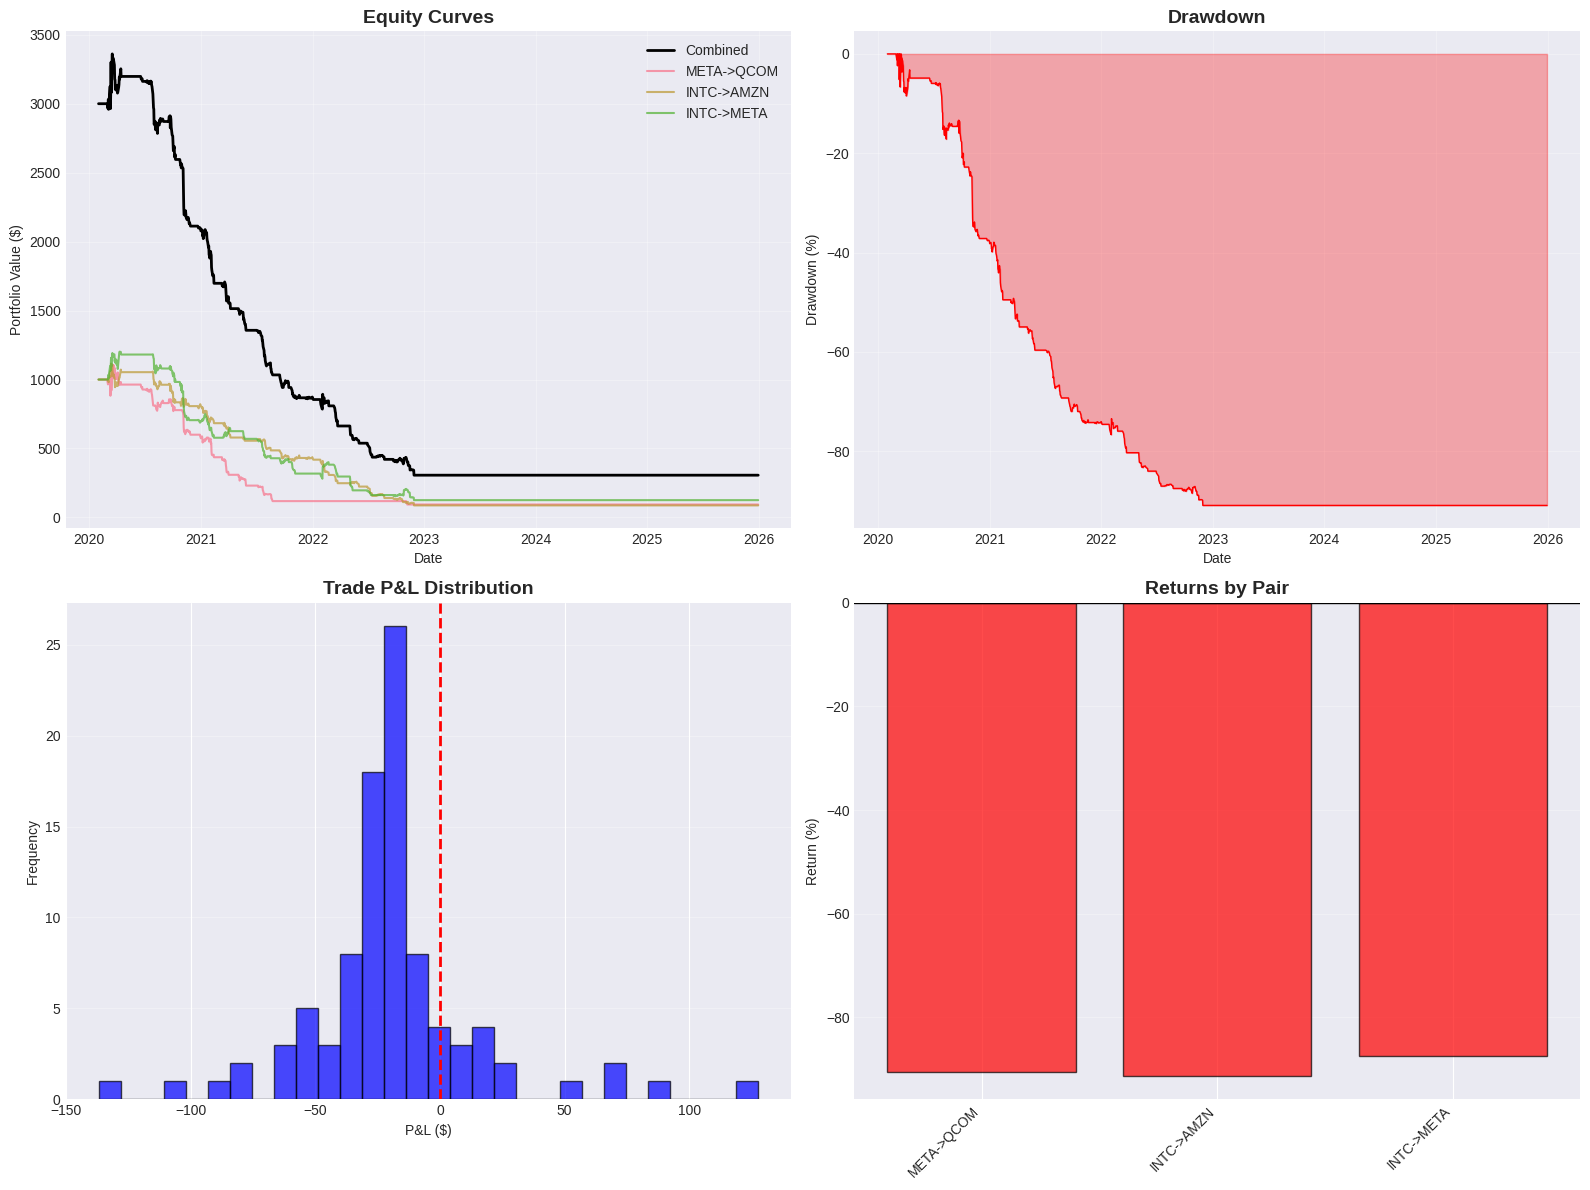

In [29]:
# Visualize results
if len(trading_pairs) > 0:
    backtester.plot_results()

In [30]:
# Create performance summary DataFrame
if len(trading_pairs) > 0:
    agg_metrics = results['aggregated']['metrics']
    
    summary_df = pd.DataFrame({
        'Metric': [
            'Total Return ($)',
            'Total Return (%)',
            'Number of Trades',
            'Win Rate (%)',
            'Profit Factor',
            'Max Drawdown (%)',
            'Sharpe Ratio',
            'Sortino Ratio',
            'Calmar Ratio'
        ],
        'Value': [
            f"${agg_metrics['total_return']:.2f}",
            f"{agg_metrics['total_return_pct']:.2f}%",
            agg_metrics['n_trades'],
            f"{agg_metrics['win_rate']:.2f}%",
            f"{agg_metrics['profit_factor']:.2f}",
            f"{agg_metrics['max_drawdown']:.2f}%",
            f"{agg_metrics['sharpe_ratio']:.2f}",
            f"{agg_metrics['sortino_ratio']:.2f}",
            f"{agg_metrics['calmar_ratio']:.2f}"
        ]
    })
    
    print("\nPerformance Summary:")
    print("="*80)
    display(summary_df)


Performance Summary:


,Metric,Value
0,Total Return ($),$-2693.65
1,Total Return (%),-89.79%
2,Number of Trades,94
3,Win Rate (%),17.02%
4,Profit Factor,0.23
5,Max Drawdown (%),90.89%
6,Sharpe Ratio,-2.21
7,Sortino Ratio,-1.51
8,Calmar Ratio,-0.35


In [31]:
# Per-pair performance comparison
if len(trading_pairs) > 0:
    pair_metrics_list = []
    for pair_name, result in results['pair_results'].items():
        metrics = result['metrics']
        pair_metrics_list.append({
            'Pair': pair_name,
            'Return ($)': f"${metrics['total_return']:.2f}",
            'Return (%)': f"{metrics['total_return_pct']:.2f}%",
            'Trades': metrics['n_trades'],
            'Win Rate': f"{metrics['win_rate']:.1f}%",
            'Max DD (%)': f"{metrics['max_drawdown']:.2f}%",
            'Sharpe': f"{metrics['sharpe_ratio']:.2f}"
        })
    
    pair_comparison_df = pd.DataFrame(pair_metrics_list)
    print("\nPer-Pair Performance:")
    print("="*80)
    display(pair_comparison_df)


Per-Pair Performance:


,Pair,Return ($),Return (%),Trades,Win Rate,Max DD (%),Sharpe
0,META->QCOM,$-906.17,-90.62%,27,14.8%,91.51%,-1.57
1,INTC->AMZN,$-912.84,-91.28%,34,14.7%,92.19%,-1.79
2,INTC->META,$-874.64,-87.46%,33,21.2%,89.57%,-1.22


## Save Results

In [32]:
# Save results to CSV files
if len(trading_pairs) > 0:
    output_dir = Path(config['output']['results_dir'])
    output_dir.mkdir(exist_ok=True)
    
    # Save trading pairs
    trading_pairs.to_csv(output_dir / 'trading_pairs.csv', index=False)
    print(f"Trading pairs saved to {output_dir / 'trading_pairs.csv'}")
    
    # Save aggregated metrics
    summary_df.to_csv(output_dir / 'performance_summary.csv', index=False)
    print(f"Performance summary saved to {output_dir / 'performance_summary.csv'}")
    
    # Save per-pair metrics
    pair_comparison_df.to_csv(output_dir / 'pair_comparison.csv', index=False)
    print(f"Pair comparison saved to {output_dir / 'pair_comparison.csv'}")
    
    # Save equity curve
    equity_df = pd.DataFrame({
        'date': results['aggregated']['dates'],
        'equity': results['aggregated']['equity_curve']
    })
    equity_df.to_csv(output_dir / 'equity_curve.csv', index=False)
    print(f"Equity curve saved to {output_dir / 'equity_curve.csv'}")
    
    print(f"\nAll results saved to {output_dir}")

Trading pairs saved to results/trading_pairs.csv
Performance summary saved to results/performance_summary.csv
Pair comparison saved to results/pair_comparison.csv
Equity curve saved to results/equity_curve.csv

All results saved to results
